# Кластеризация

Когда говорят про задачу кластеризации, подразумевают примерно следующее:

У нас есть неразмеченные данные, и мы хотим поделить эти данные по каким-то группам, где в каждой группе будут объекты, похожие друг на друга. Под похожестью как правило понимается выбранная метрика расстояния.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/clustering_task.png" width="700"></center>

Основные цели кластеризации:

* Исследование данных. Мы хотим понять, какие кластеры являются ярко выраженными, и сделать дополнительные выводы о наших данных.
* Нахождение аномалий/выбросов. Мы можем искать объекты, которые сильно отличаются от всех остальных и не принадлежат никакому кластеру.
* Создание дополнительных признаков. Кластер для объекта уже является дополнительным категориальным признаком.
* Непосредственно классификация. Например, можем считать получившиеся кластеры классами и классифицировать объекты таким образом.

Алгоритмов кластеризации существует большое количество, и все работают по-разному, имеют разные параметры для настройки. Мы рассмотрим два наиболее популярных: [K-Means 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) и [DBSCAN 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/sphx_glr_plot_cluster_comparison.png" width="800"></center>

<center><em>Source: <a href="https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods"> Overview of clustering methods</a></em></center>

## Алгоритм K-Means

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/kmeans.png" width="750"></center>

1. Выбираем количество кластеров $k$, которое нам кажется оптимальным для наших данных.
2. Определяем начальное положение центроидов кластеров, случайным образом или по какому-либо правилу.
3. Для каждой точки нашего набора данных считаем расстояние до центроидов. Относим точки к ближайшим центроидам.
4. Перемещаем каждый центроид в центр получившихся кластеров.
5. Повторяем шаги 3–4 до тех пор, пока центроиды не перестанут значительно сдвигаться.


[[demo] 🎮 Интерактивная визуализация алгоритма K-Means](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)

Особенности K-Means:

* Сильно зависит от параметра $k$ и начального положения центроидов.
* Кластеры получаются гиперсферическими, с более сложными формами алгоритм не справляется.
* Все точки относятся к какому-то кластеру, явных выбросов нет.



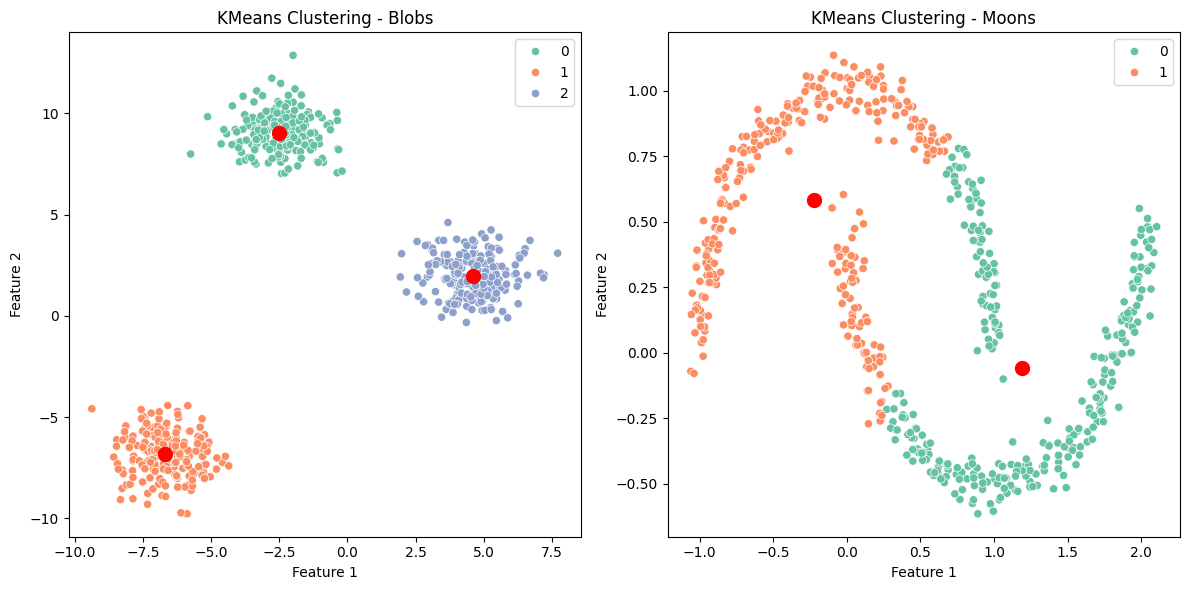

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_moons

x_blobs, _ = make_blobs(n_samples=600, n_features=2, centers=3, random_state=42)
x_moons, _ = make_moons(n_samples=600, noise=0.05, random_state=42)


def plot_kmeans_clustering(ax, data, n_clusters, title):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    kmeans.fit(data)
    kmeans_labels = kmeans.predict(data)

    sns.scatterplot(
        x=data[:, 0], y=data[:, 1], hue=kmeans_labels, palette="Set2", ax=ax
    )
    ax.scatter(
        kmeans.cluster_centers_[:, 0],
        kmeans.cluster_centers_[:, 1],
        s=100,
        c="red",
        marker="o",
    )
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_kmeans_clustering(
    axes[0], x_blobs, n_clusters=3, title="KMeans Clustering - Blobs"
)
plot_kmeans_clustering(
    axes[1], x_moons, n_clusters=2, title="KMeans Clustering - Moons"
)

plt.tight_layout()
plt.show()

## Алгоритм DBSCAN

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/dbscan.png" width="750"></center>

DBSCAN (Density-based spatial clustering of applications with noise, плотностный алгоритм пространственной кластеризации с присутствием шума), как следует из названия, оперирует плотностью данных. На вход требуется матрица близости и два параметра:
*  `eps` — радиус $\varepsilon$-окрестности, в которой мы ищем похожие объекты (радиус кружков на картинке).
* `min_samples` — количество соседей, которое должен иметь объект, чтобы не быть одиночкой. У нас `min_samples=3`.


Алгоритм выглядит следующим образом:
1. Берем случайную точку из данных.
2. Если рядом с ней меньше трёх точек (количество соседей), переносим ее в список возможных одиночек и выбираем другую точку.

Иначе:
3. Исключаем ее из списка точек, которые надо посмотреть.
4. Ставим ей зеленую метку и создаем новый кластер, к которому относится пока только одна точка.
5. Просматриваем всех ее соседей. Если ее сосед уже в списке потенциальных одиночек и рядом с ним мало других точек, то перед нами край кластера. Для простоты можно сразу пометить его жёлтым флагом, присоединить к группе и продолжить обход. Если сосед тоже оказывается «зелёным», то он не стартует новую группу, а присоединяется к уже созданной. Кроме этого мы добавляем в список обхода соседей соседа. Повторяем этот пункт, пока список обхода не окажется пуст.
6. Повторяем шаги 1–5, пока так или иначе не посмотрим все точки.
7. Разбираемся со списком одиночек. Если мы уже раскидали всех краевых, то в нём остались только выбросы-одиночки — можно сразу закончить. Если нет, то нужно как-нибудь распределить точки, оставшиеся в списке.

[[blog] ✏️ Подробнее про DBSCAN](https://habr.com/ru/post/322034/)

[[demo] 🎮 Интерактивная визуализация алгоритма DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

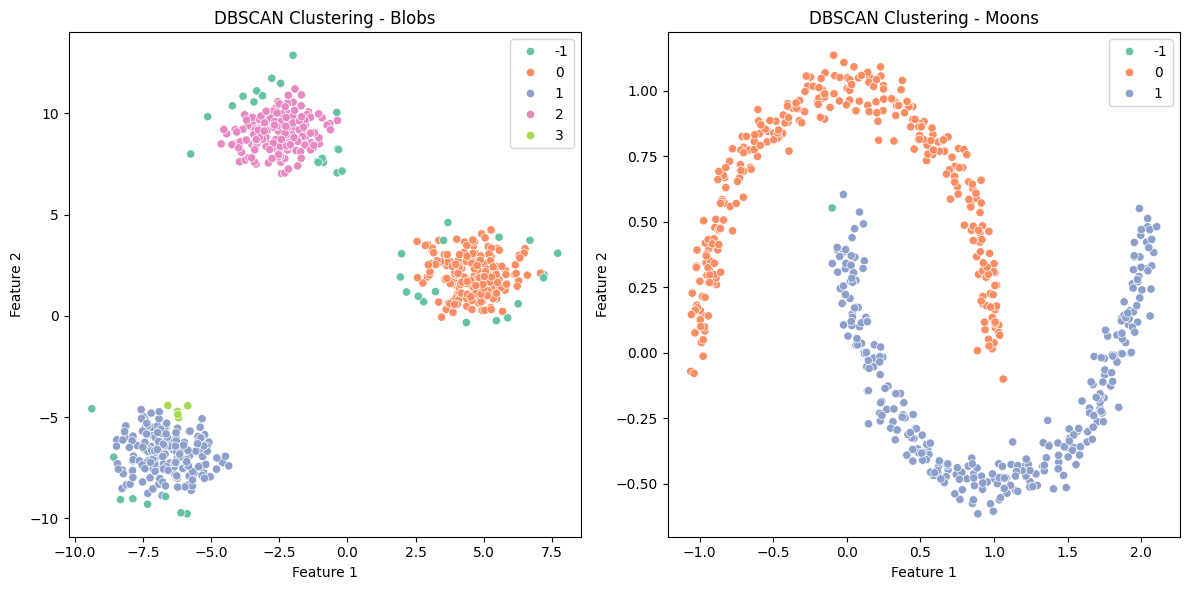

In [ ]:
from sklearn.cluster import DBSCAN


def plot_dbscan_clustering(ax, data, eps, min_samples, title):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(data)

    sns.scatterplot(
        x=data[:, 0], y=data[:, 1], hue=dbscan_labels, palette="Set2", ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_dbscan_clustering(
    axes[0], x_blobs, eps=0.5, min_samples=5, title="DBSCAN Clustering - Blobs"
)
plot_dbscan_clustering(
    axes[1], x_moons, eps=0.15, min_samples=5, title="DBSCAN Clustering - Moons"
)

plt.tight_layout()
plt.show()